In [1]:
import numpy as np
import os
import json
import re
import pickle
import datetime
import tensorflow as tf
import pandas as pd
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image, display, HTML
from tensorflow.contrib.layers import variance_scaling_initializer
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.data import Dataset, Iterator
from tensorflow.contrib import learn
from sklearn.metrics import f1_score, classification_report

###### Do not modify here ###### 
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = graph_def
    #strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
###### Do not modify  here ######

###### Do not modify here ###### 

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

## Prepare functions 

In [2]:
tknzr = TweetTokenizer()

#Define function to preprocess tweets
def filter_tweet(tweet, token = tknzr):
    try:
        tweet = re.sub('https?:\/\/\S+','URLTOK',tweet.lower().strip()) # url
        tweet = re.sub('@(?:[a-zA-Z]+|[0-9 \/]+)', '<M>', tweet) # mention
        tweet = re.sub('#(?:[a-zA-Z]+|[0-9 \/]+)', '<H>', tweet) # hashtag
        tweet = re.sub('(\:|\=)(?:\)|\-|\(|D| )+', '', tweet) # emoticon
    except:
        print(tweet)
        return [0]
    return token.tokenize(tweet) # return tokenized

In [3]:
def word_transformation(tweets, max_document_length = 60):
    transformation = []
    for tweet in tweets:
        tweet_index = [0]*max_document_length
        for i, word in enumerate(tweet):
            if i == 60: #skip words after the 60th 
                break
            if vocabulary_dict.get(word):
                tweet_index[i] = vocabulary_dict[word]
            else:
                tweet_index[i] = 0
        transformation.append(tweet_index)
    return np.array(transformation)

## Load distant supervised learning model

In [4]:
def emotion2label(emo):
    if emo =='joy':            return 0
    elif emo =='sadness':      return 1
    elif emo =='fear':         return 2
    elif emo =='anger':        return 3
    elif emo =='anticipation': return 4
    elif emo =='trust':        return 5
    elif emo =='surprise':     return 6
    elif emo =='disgust':      return 7

In [5]:
#Load word2vec model
distance_supervised_embeddings = np.load("data/embedding/distance_supervised_2M_200.npy")
print(distance_supervised_embeddings.shape)

vocabulary_dict = pickle.load(open("data/embedding/distance_supervised_2M_200.pickle", "rb"))
print(len(vocabulary_dict))

(496895, 200)
496893


In [6]:
#Load training data
en_train = pd.read_csv('data/emo/Train/train.tsv', delimiter='\t', names=["emotion", "tweet"])
en_train.groupby('emotion').count()

,tweet
emotion,
anger,332416
anticipation,86100
disgust,17966
fear,352271
joy,351119
sadness,439736
surprise,165751
trust,220511


In [7]:
#Map emotion to label for each row
en_train["label"] = en_train["emotion"].map(emotion2label)
en_train.head()

,emotion,tweet,label
0,anticipation,<M>: <H> <H> <H> <H> <H> <H> <M> ... You DTM. ...,4
1,anger,stop posting every damn thing you do on instag...,3
2,trust,<H> youll never meet justin bieber. hell never...,5
3,anticipation,<H> &amp; count down the days until May! <H> <...,4
4,surprise,<M> Holme upon Spalding moor won rock challeng...,6


In [8]:
# train_tweets = [filter_tweet(tweet) for tweet in en_train["tweet"]]
# print(len(train_tweets))

In [9]:
max_length = 60
#train_tweets_ = word_transformation(train_tweets, max_length)
train_tweets_ = np.load("data/tweets/tweets_train.npy")
train_tweets_.shape

(1965870, 60)

In [10]:
train_tweets_[0]

array([349899,      1,      1,      1,      1,      1,      1, 349899,
          558,     35, 152312,     59,   3912,     59,    986,    707,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0])

In [11]:
train_label_ = en_train["label"].as_matrix()

In [12]:
# Load Testing data
en_test = pd.read_csv('data/emo/Test/test.tsv', delimiter='\t',names=["tweet","emotion", "emotion2", "emotion3"])
en_test.head()

,tweet,emotion,emotion2,emotion3
0,#championsleague i am cmng to watch you...all ...,joy,anticipation,trust
1,#mufc wages up19% in13/14 season with #dimaria...,anticipation,fear,NaN
2,#sterlings getting some great experience here....,joy,trust,anticipation
3,1 more week then it's block 208 kop grandstand...,anticipation,joy,trust
4,1 week from today! the @championsleague return...,anticipation,joy,trust


In [13]:
en_test['label'] = en_test['emotion'].map(emotion2label).fillna(-1).astype('int')
en_test['label2'] = en_test['emotion2'].map(emotion2label).fillna(-1).astype('int')
en_test['label3'] = en_test['emotion3'].map(emotion2label).fillna(-1).astype('int')
en_test.head()

,tweet,emotion,emotion2,emotion3,label,label2,label3
0,#championsleague i am cmng to watch you...all ...,joy,anticipation,trust,0,4,5
1,#mufc wages up19% in13/14 season with #dimaria...,anticipation,fear,NaN,4,2,-1
2,#sterlings getting some great experience here....,joy,trust,anticipation,0,5,4
3,1 more week then it's block 208 kop grandstand...,anticipation,joy,trust,4,0,5
4,1 week from today! the @championsleague return...,anticipation,joy,trust,4,0,5


In [14]:
en_test.groupby('emotion').count()

,tweet,emotion2,emotion3,label,label2,label3
emotion,,,,,,
anger,223,194,57,223,223,223
anticipation,272,146,61,272,272,272
disgust,183,118,91,183,183,183
fear,119,99,43,119,119,119
joy,591,356,93,591,591,591
sadness,218,176,64,218,218,218
surprise,246,187,49,246,246,246
trust,102,94,59,102,102,102


## Emotion Model 

### Prepare training / validation data 

In [16]:
from sklearn.model_selection import train_test_split
from collections import defaultdict
import random

In [17]:
def label2emotion_4(label):
    if label == 0:            return 'joy'
    elif label == 1:      return 'sadness'
    elif label == 2:         return 'fear'
    elif label == 3:        return 'anger'
    elif label == 4:       return 'others'
    
def label2emotion(label):
    if label == 0:          return 'joy'
    elif label == 1:        return 'sadness'
    elif label == 2:        return 'fear'
    elif label == 3:        return 'anger'
    elif label == 4:        return 'anticipation'
    elif label == 5:        return 'trust'
    elif label == 6:        return 'surprise'
    elif label == 7:        return 'disgust'
   

In [18]:
tweets_train_merge = np.concatenate((train_tweets_, train_label_.reshape((train_label_.shape[0],1))), axis=1)
tweets_train_merge.shape

(1965870, 61)

In [19]:
tweet_category_dict = defaultdict(lambda:[])

for tweet_and_lab in tweets_train_merge:
    tweet_category_dict[tweet_and_lab[-1]].append(tweet_and_lab[:-1])

In [20]:
for emo in tweet_category_dict:
    print("Emo {:12s} has {:6d} tweets".format(label2emotion(emo), len(tweet_category_dict[emo])))

Emo joy          has 351119 tweets
Emo sadness      has 439736 tweets
Emo fear         has 352271 tweets
Emo anger        has 332416 tweets
Emo anticipation has  86100 tweets
Emo trust        has 220511 tweets
Emo surprise     has 165751 tweets
Emo disgust      has  17966 tweets


In [21]:
train_category_dict= defaultdict(lambda:[])
test_category_dict = defaultdict(lambda:[])

for emo, tweet_list in tweet_category_dict.items():
    random.shuffle(tweet_list)
    test_category_dict[emo] = tweet_list[:1800]
    train_category_dict[emo]= tweet_list[1800:]

In [22]:
for emo, tweet_list in train_category_dict.items():
    print("Train - Emo {:12s} has {:6d} tweets".format(label2emotion(emo), len(tweet_list)))
    
for emo, tweet_list in test_category_dict.items():
    print("Test  - Emo {:12s} has {:6d} tweets".format(label2emotion(emo), len(tweet_list)))

Train - Emo joy          has 349319 tweets
Train - Emo sadness      has 437936 tweets
Train - Emo fear         has 350471 tweets
Train - Emo anger        has 330616 tweets
Train - Emo anticipation has  84300 tweets
Train - Emo trust        has 218711 tweets
Train - Emo surprise     has 163951 tweets
Train - Emo disgust      has  16166 tweets
Test  - Emo joy          has   1800 tweets
Test  - Emo sadness      has   1800 tweets
Test  - Emo fear         has   1800 tweets
Test  - Emo anger        has   1800 tweets
Test  - Emo anticipation has   1800 tweets
Test  - Emo trust        has   1800 tweets
Test  - Emo surprise     has   1800 tweets
Test  - Emo disgust      has   1800 tweets


In [23]:
tweets_valid, senti_valid = [], []
for emo, tweet_list in test_category_dict.items():
    tweets_valid += tweet_list
    senti_valid += [emo]*len(tweet_list)
tweets_valid = np.array(tweets_valid)

### Build model

In [24]:
from sklearn.metrics import confusion_matrix
import itertools

In [25]:
n_input = 60
n_output = 5
learning_rate = 1

embedding_size = distance_supervised_embeddings.shape[1]
filter_sizes = [3,3]
num_filters = 300
pooling_size = 3
pooling_strides = 2
epochs_num = 25
batch_size = 128

In [18]:
reset_graph()

X = tf.placeholder(tf.int32, shape = (None, n_input), name = "Input_X")
y = tf.placeholder(tf.int32, shape = (None), name = "Y")
mode = tf.placeholder(tf.bool, name = "Mode")

# Load Embedding Model
with tf.device('/cpu:0'), tf.name_scope("embedding"):
    word2vec = tf.Variable(tf.constant(0.0, shape = distance_supervised_embeddings.shape),
                    trainable=False, name="word2vec") # trainable=False, means not update these embeddings

embedded_chars = tf.nn.embedding_lookup(word2vec, X)
embedded_chars_expanded = tf.expand_dims(embedded_chars, -1) 
# ex: convert [[1,2]] to [[1],[2]], that is shape (2,) to (2,1)

# 1st convolution layer
conv1 = tf.layers.conv2d(embedded_chars_expanded, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[0], distance_supervised_embeddings.shape[1]),
                         strides = (1,1), 
#                          padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_1st"
                        )

pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[pooling_size, 1], strides=pooling_strides)

# 2nd convolution layer
conv2 = tf.layers.conv2d(pool1, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[1], 1),
                         strides = (1,1), 
                         padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_2nd"
                        )
print(conv2.shape)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[28, 1], strides=1)

# Dense Layer, Combine all the pooled features
pool2_flat = tf.reshape(pool2, [-1, num_filters])

dense = tf.layers.dropout(inputs = pool2_flat, rate = 0.3, training = mode, name="Dropout")

dense = tf.layers.dense(inputs=dense, units=512, activation=tf.nn.relu, name = "Fully_connect")


# Logits Layer
logits = tf.layers.dense(inputs=dense, 
                         units=n_output, 
#                          activation=tf.nn.softmax, 
#                          kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         name = "Logits")

# Define Loss Function
cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits, name="Cross_Entropy"))

# Define Training Process
train_step = tf.train.AdadeltaOptimizer(learning_rate, epsilon=1e-6).minimize(cross_entropy)

# Define Accuracy
predicted_class = tf.argmax(logits,1, output_type=tf.int32)
correct_predict = tf.equal(y, predicted_class) # [True, False ..., True]
accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float32)) # [True, False ..., True] --> [1,0,...,1]

(?, 28, 1, 300)


In [19]:
with tf.Session() as sess:
    show_graph(tf.get_default_graph().as_graph_def())

In [26]:
# prepare the training batch in python
from sklearn.utils import shuffle

def data_iterator(X, y, batch_size = batch_size):
    """ A simple data iterator """
    batch_idx = 0
    while True:
        for batch_idx in range(0, len(X), batch_size):
            trains_batch = X[batch_idx:batch_idx+batch_size]
            labels_batch = y[batch_idx:batch_idx+batch_size]
            yield trains_batch, labels_batch

def emo_iterator(X, y, batch_size = 8):
    """ A simple emotion iterator """
    batch_idx = 0
    while True:
        for batch_idx in range(0, len(X), batch_size):
            trains_batch = X[batch_idx:batch_idx+batch_size]
            yield trains_batch, [y]*len(trains_batch)  
            
def balance_iterator(emo_iters, batch_size = batch_size):            
    """Sample Balanced Iterator"""
    iter_rounds = int(batch_size / len(emo_iters) / 8)
    print(iter_rounds)
    while True:
        train_batch = []
        label_batch = []
        for iter_ in emo_iters:
            for _ in range(iter_rounds):
                temp_train, temp_test = next(iter_)
                train_batch += temp_train
                label_batch += temp_test
            
        train_batch, label_batch = shuffle(train_batch, label_batch, random_state=42)
        yield train_batch, label_batch


In [27]:

# iter_ = data_iterator(tweets_train, senti_train)

valid_iter_ = data_iterator(tweets_valid, senti_valid)

emo_iters = [emo_iterator(tweet_list, emo) for emo, tweet_list in train_category_dict.items()]
    

balance_train_iter = balance_iterator(emo_iters)

In [34]:
def training_evaluation(sess, iterater, rounds_of_epochs, f1_standard = 'weighted'):
    loss_list = []
    predict_res = np.zeros(batch_size)
    true_label = np.zeros(batch_size)
    acc_list = []
    for _ in range(rounds_of_epochs):
        X_eval, y_eval = next(iterater) # Get the mini-batch data sample from tensorflow
        eval_loss, eval_pred, eval_accuracy = sess.run([cross_entropy, predicted_class, accuracy], feed_dict={X:X_eval, y:y_eval, mode:False})
        loss_list.append(eval_loss)
        predict_res = np.concatenate((predict_res, eval_pred))
        true_label = np.concatenate((true_label, y_eval))
        acc_list.append(eval_accuracy)
#     print(eval_loss, eval_pred, eval_accuracy)
    # return loss, f1, acc, (logits, labels)
    return sum(loss_list)/len(loss_list), f1_score(true_label[batch_size:], predict_res[batch_size:], average= f1_standard), sum(acc_list)/len(acc_list), (predict_res, true_label)

In [63]:
def classification_report_confusion_matrix(pred_label, class_names = ['joy','sadness','fear','anger', 'others'], chart=True):
   
    print(classification_report(pred_label[1], pred_label[0], target_names=class_names))
    if chart:
        pred_res_pd = pd.DataFrame({'pred':pred_label[0], 'label':pred_label[1]})
        cfm = confusion_matrix(y_pred=pred_res_pd.pred.map(label2emotion), y_true=pred_res_pd.label.map(label2emotion), labels=class_names)
        plt.figure(figsize=(9,6))
        plot_confusion_matrix(cfm, classes=class_names, normalize=True,
                              title='Normalized confusion matrix')
        plt.show()

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# round_of_epochs = int(tweets_train.shape[0]/batch_size)
round_of_epochs = 2000
valid_round_of_epochs = int(tweets_valid.shape[0]/batch_size)
# valid_round_of_epochs = 1

train_loss = []
valid_loss = []
test_loss  = []

train_f1 = []
valid_f1 = []
test_f1 = []
x_axis = np.arange(0., epochs_num, 1) +1
saver = tf.train.Saver() # to store the model

best_valid_acc = 0

testing_res = []
with tf.Session() as sess:
    # Initialize all variables
#     if os.path.exists('./model/emo_504.ckpt.meta'):
#         print ("Model Restore")
#         saver.restore(sess, './model/emo_504.ckpt')
#     else:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(word2vec.assign(distance_supervised_embeddings))# Assign the pretrain word2vec
    
    for epochs in range(epochs_num): # starting the training process and set the epochs_num
        for _ in range(round_of_epochs):
#             train, label = sess.run(train_next_batch) # Get the mini-batch data sample from tensorflow
#             train, label = next(iter_) # Get the mini-batch data sample from tensorflow
            train, label = next(balance_train_iter) # Get the balance mini-batch data sample
#             sess.run(train_step, feed_dict={X:train, y:label, mode:True}) # Feed the features, labe, training_mode  to network to train
            sess.run([train_step, cross_entropy, predicted_class, accuracy], feed_dict={X:train, y:label, mode:True}) # Feed the features, labe, training_mode  to network to train
    
        # An epoch finish
        
        # Training evaluation
        train_res_loss, train_res_f1, train_res_acc, _ = training_evaluation(sess, balance_train_iter, round_of_epochs)
        
        # Validation evaluation
        valid_res_loss, valid_res_f1, valid_res_acc, pred_label  = training_evaluation(sess, valid_iter_, valid_round_of_epochs)

        train_loss.append(train_res_loss)
        valid_loss.append(valid_res_loss)
        train_f1.append(train_res_f1)
        valid_f1.append(valid_res_f1)
        
        #test_pred, test_acc = sess.run([predicted_class, accuracy], feed_dict={X:tweets_test, y:senti_test, mode:False})
        #testing_res.append(test_pred)
        
        print("{} - {:3d} epoch, loss:{:.3f}/{:.3f}, accuracy:{:.3f}/{:.3f}, f1-score:{:.3f}/{:.3f}".format(
            datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            epochs+1,
            train_res_loss, 
            valid_res_loss,
            train_res_acc,
            valid_res_acc,
            train_res_f1,
            valid_res_f1
            #test_acc
            )
        )
        classification_report_confusion_matrix(pred_label)
        
        
        if best_valid_acc < valid_res_f1:
            best_valid_acc = valid_res_f1
            save_path = saver.save(sess, "./model/emo_4/emo_"+str(valid_res_f1)[2:5]+".ckpt")
        
    plt.rcParams['font.size'] = 14
    plt.plot(x_axis, train_loss, 'r', x_axis, valid_loss, 'b')
    plt.legend(['Train', 'Valid'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(cross entropy)')
    plt.show()
    plt.clf()
    plt.plot(x_axis, train_f1, x_axis, valid_f1)
    plt.legend(['Train', 'Valid'], loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.show()


## Load sentiment data 

In [37]:
%%time

with open('data/distance_supervised/sad') as f:
    sad_tweet = [filter_tweet(line) for line in f.readlines()]

with open('data/distance_supervised/distance_supervised_tweets_corrected') as f:
    sad_tweet += [filter_tweet(line.split('\t')[3]) for line in f.readlines()]

with open('data/distance_supervised/distance_supervised_tweets_2_corrected') as f:
    sad_tweet += [filter_tweet(line.split('\t')[3]) for line in f.readlines()]

with open('data/distance_supervised/distance_supervised_tweets_3_corrected') as f:
    sad_tweet += [filter_tweet(line.split('\t')[3]) for line in f.readlines()]
print(len(sad_tweet))

1252941
CPU times: user 42.7 s, sys: 260 ms, total: 43 s
Wall time: 42.9 s


In [38]:
%%time
with open('data/distance_supervised/smile') as f:
    smile_tweet = [filter_tweet(line) for line in f.readlines()][:len(sad_tweet)]
print(len(smile_tweet))

1252941
CPU times: user 1min 37s, sys: 804 ms, total: 1min 38s
Wall time: 1min 38s


In [39]:
%%time
max_length = 60
sad_tweet = list(filter(lambda tweet: len(tweet) <= max_length, sad_tweet))
print(len(sad_tweet))
smile_tweet = list(filter(lambda tweet: len(tweet) <= max_length, smile_tweet))
print(len(smile_tweet))

1252345
1252910
CPU times: user 352 ms, sys: 0 ns, total: 352 ms
Wall time: 349 ms


In [40]:
sad_array = word_transformation(sad_tweet)
print(sad_array.shape)
smile_array = word_transformation(smile_tweet)
print(smile_array.shape)

(1252345, 60)
(1252910, 60)


In [41]:
sad_array[0]

array([327, 403,  75, 198,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0])

In [61]:
total_tweets = np.concatenate((smile_array[:sad_array.shape[0]], sad_array), axis=0)
total_labels = np.concatenate((np.zeros(sad_array.shape[0], dtype=np.int32), np.ones(sad_array.shape[0], dtype=np.int32)), axis=0)

In [ ]:
#del sad_tweet, smile_tweet

## Sentiment supervised learning 

In [62]:
X_train, X_valid, y_train, y_valid = train_test_split(total_tweets, 
                                                      total_labels, 
                                                      test_size=0.1, 
                                                      random_state=42)
print(X_train.shape)
print(X_valid.shape)

(2254221, 60)
(250469, 60)


In [15]:
n_input = 60
n_output = 2
learning_rate = 1

embedding_size = distance_supervised_embeddings.shape[1]
filter_sizes = [4,3]
num_filters = 200
pooling_size = 4
pooling_strides = 2
epochs_num = 20
batch_size = 128

In [16]:
reset_graph()

X = tf.placeholder(tf.int32, shape = (None, n_input), name = "Input_X")
y = tf.placeholder(tf.int32, shape = (None), name = "Y")
mode = tf.placeholder(tf.bool, name = "Mode")

# Load Embedding Model
with tf.device('/cpu:0'), tf.name_scope("embedding"):
    word2vec = tf.Variable(tf.constant(0.0, shape = distance_supervised_embeddings.shape),
                    trainable=False, name="word2vec") # trainable=False, means not update these embeddings

embedded_chars = tf.nn.embedding_lookup(word2vec, X)
embedded_chars_expanded = tf.expand_dims(embedded_chars, -1) # ex: convert [[1,2]] to [[1],[2]], that is shape (2,) to (2,1)

# 1st convolution layer
conv1 = tf.layers.conv2d(embedded_chars_expanded, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[0], distance_supervised_embeddings.shape[1]),
                         strides = (1,1), 
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_1st_senti"
                        )

pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[4, 1], strides=2)

# 2nd convolution layer
conv2 = tf.layers.conv2d(pool1, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[1], 1),
                         strides = (1,1), 
                         padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_2nd_senti"
                        )

pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[27, 1], strides=1)

# Dense Layer, Combine all the pooled features
pool2_flat = tf.reshape(pool2, [-1, num_filters])

dense = tf.layers.dense(inputs=pool2_flat, units=512, activation=tf.nn.relu, name = "Fully_connect_senti")
# dense = tf.layers.dropout(inputs = dense, rate = 0.3, training = mode)

# Logits Layer
logits = tf.layers.dense(inputs=dense, 
                         units=n_output, 
                         name = "Logits")

# # Define Loss Function
cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits, name="Cross_Entropy"))

# # Define Training Process
train_step = tf.train.AdadeltaOptimizer(learning_rate).minimize(cross_entropy)


# # Define Accuracy
predicted_class = tf.argmax(logits,1, output_type=tf.int32)
correct_predict = tf.equal(y, predicted_class) # [True, False ..., True]
accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float32)) # [True, False ..., True] --> [1,0,...,1]

In [39]:

# with tf.Session() as sess:
#     show_graph(tf.get_default_graph().as_graph_def())

In [72]:
senti_iter_ = data_iterator(X_train, y_train, batch_size)

senti_valid_iter_ = data_iterator(X_valid, y_valid, batch_size)

In [74]:
round_of_epochs = int(X_train.shape[0]/batch_size)
print(round_of_epochs)

valid_round_of_epochs = int(X_valid.shape[0]/batch_size)
print(valid_round_of_epochs)

train_loss = []
valid_loss = []
train_f1 = []
valid_f1 = []

saver = tf.train.Saver() # to store the model

with tf.Session() as sess:
    # Initialize all variables
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    sess.run(word2vec.assign(distance_supervised_embeddings))# Assign the pretrain word2vec
    for epochs in range(epochs_num)[:3]:
        for _ in range(round_of_epochs):
            train, label = next(senti_iter_)
            sess.run(train_step, feed_dict={X:train.tolist(), y:label.tolist()}) # Feed the features, labe, training_mode  to network to train

        train_res_loss, train_res_f1, train_res_acc, pred_label  = training_evaluation(sess, senti_iter_, round_of_epochs)
        
        valid_res_loss, valid_res_f1, valid_res_acc, pred_label  = training_evaluation(sess, senti_valid_iter_, valid_round_of_epochs)

        train_loss.append(train_res_loss)
        valid_loss.append(valid_res_loss)
        train_f1.append(train_res_f1)
        valid_f1.append(valid_res_f1)
        
        print("{} - {:3d} epoch, loss:{:.3f}/{:.3f}, accuracy:{:.3f}/{:.3f}, f1-score:{:.3f}/{:.3f}".format(
            datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            epochs+1,
            train_res_loss, 
            valid_res_loss,
            train_res_acc,
            valid_res_acc,
            train_res_f1,
            valid_res_f1
            #test_acc
            )
        )
#         save_path = saver.save(sess, "./model/senti/senti_"+str(valid_res_f1)[2:5]+".ckpt")

17611
1956
2018-01-08 12:29:59 -   1 epoch, loss:0.299/0.314, accuracy:0.868/0.861, f1-score:0.868/0.860
2018-01-08 12:33:09 -   2 epoch, loss:0.278/0.305, accuracy:0.880/0.866, f1-score:0.880/0.866
2018-01-08 12:36:20 -   3 epoch, loss:0.265/0.305, accuracy:0.885/0.868, f1-score:0.885/0.868


## Transfer Learning by Combine 4emo + Sentiment features map to predict 8 emo

In [121]:
dropout_rate = 0.5

In [108]:
tf.reset_default_graph()
    
senti_graph = tf.Graph()
with senti_graph.as_default() as g:
    restore_saver_senti = tf.train.import_meta_graph("./model/senti/senti_867.ckpt.meta") # load meta graph
    X_senti = g.get_tensor_by_name("Input_X:0") # assign placeholder variables with input X
    Y_senti = g.get_tensor_by_name("Y:0")
    mode_senti = g.get_tensor_by_name("Mode:0")
#     feature_map_senti = g.get_tensor_by_name("Fully_connect_senti/Relu:0").op.outputs[0]
    feature_map_senti = g.get_tensor_by_name("Fully_connect_senti/MatMul:0").op.inputs[0]
    logit_senti = g.get_tensor_by_name("Logits/BiasAdd:0").op.inputs[0]
    init_senti = tf.global_variables_initializer()

emotion_graph = tf.Graph()
with emotion_graph.as_default() as g:
    restore_saver_emotion = tf.train.import_meta_graph("./model/emo_4/emo_634.ckpt.meta") # load meta graph
    X_emo = g.get_tensor_by_name("Input_X:0") # assign placeholder variables with input X
    Y_emo = g.get_tensor_by_name("Y:0")
    mode_emo = g.get_tensor_by_name("Mode:0")    
#     feature_map_emo = g.get_tensor_by_name("Fully_connect/Relu:0").op.outputs[0]
    feature_map_emo = g.get_tensor_by_name("Fully_connect/MatMul:0").op.inputs[0]
    logit_emo = g.get_tensor_by_name("Logits/BiasAdd:0").op.inputs[0]
    init_emo = tf.global_variables_initializer()

    

sess_senti = tf.Session(graph=senti_graph)
sess_senti.run(init_senti)
restore_saver_senti.restore(sess_senti, "./model/senti/senti_867.ckpt")    

sess_emotion = tf.Session(graph=emotion_graph)
sess_emotion.run(init_emo)
restore_saver_emotion.restore(sess_emotion, "./model/emo_4/emo_634.ckpt")



INFO:tensorflow:Restoring parameters from ./model/senti/senti_867.ckpt
INFO:tensorflow:Restoring parameters from ./model/emo_4/emo_634.ckpt


In [122]:
tf.reset_default_graph()

concate_feature_map = tf.placeholder(tf.float32, (None, 507), name="Concate_X")
concate_y = tf.placeholder(tf.int32, shape = (None), name = "Y")
concate_mode = tf.placeholder(tf.bool, name = "Concate_Mode")

dense = tf.layers.dropout(inputs = concate_feature_map, rate = dropout_rate, training = concate_mode, name="Dropout_512_2")

dense = tf.layers.dense(inputs=dense, 
                        units=512, 
                        activation=tf.nn.relu, 
                        name = "Fully_connect_1")

dense = tf.layers.dropout(inputs = dense, rate = dropout_rate, training = concate_mode, name="Dropout")

dense = tf.layers.dense(inputs=dense, 
                        units=512, 
                        activation=tf.nn.relu, 
                        name = "Fully_connect_2")

# Logits Layer
logits = tf.layers.dense(inputs=dense, 
                         units=8, 
                         name = "Logits")

# Define Loss Function
cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=concate_y, logits=logits, name="Cross_Entropy"))

# Define Training Process
train_step = tf.train.AdadeltaOptimizer(1).minimize(cross_entropy)
# train_step = tf.train.AdamOptimizer(0.00023).minimize(cross_entropy)

# Define Accuracy
predicted_class = tf.argmax(logits,1, output_type=tf.int32)
correct_predict = tf.equal(concate_y, predicted_class) # [True, False ..., True]
accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float32)) # [True, False ..., True] --> [1,0,...,1]
top_2_correct_predict = tf.nn.in_top_k(logits, concate_y, 2) # if one of top 2 predict correct return true
top_2_accuracy = tf.reduce_mean(tf.cast(top_2_correct_predict, tf.float32)) # [True, False ..., True] --> [1,0,...,1]



In [123]:
with tf.Session() as sess:
    show_graph(tf.get_default_graph().as_graph_def())

In [124]:
def training_evaluation_merge(sess, sess1, sess2, iterater, rounds_of_epochs, f1_standard = 'weighted'):
    loss_list = []
    predict_res = np.zeros(batch_size)
    true_label = np.zeros(batch_size)
    acc_list = []
    top2acc_list = []
    for _ in range(rounds_of_epochs):
        X_eval, y_eval = next(iterater) # Get the mini-batch data sample from tensorflow

        senti_logit = sess_senti.run([feature_map_senti, logit_senti], feed_dict={X_senti: X_eval, Y_senti: y_eval, mode_senti:False})
        emoti_logit = sess_emotion.run([feature_map_emo, logit_emo], feed_dict={X_emo: X_eval, Y_emo: y_eval, mode_emo:False})
        merge_res = np.concatenate(senti_logit+emoti_logit, 1)
#         if len(X_eval) != 128: print(merge_res.shape)
#         if len(y_eval) != 128: print(len(y_eval))
        eval_loss, eval_pred, eval_accuracy, top2_acc = sess.run([cross_entropy, predicted_class, accuracy, top_2_accuracy], feed_dict={concate_feature_map:merge_res, concate_y:y_eval, concate_mode:False})
        
        loss_list.append(eval_loss)
        predict_res = np.concatenate((predict_res, eval_pred))
        true_label = np.concatenate((true_label, y_eval))
        acc_list.append(eval_accuracy)
        top2acc_list.append(top2_acc)
    return sum(loss_list)/len(loss_list), f1_score(true_label[batch_size:], predict_res[batch_size:], average= f1_standard), sum(acc_list)/len(acc_list), sum(top2acc_list)/len(top2acc_list), (predict_res, true_label)

## dropout 0.3, dense 512  & 512 & convolutional feature map layer + logits

2018-01-09 16:50:17 -  1 epoch, loss:1.442/1.440, accuracy:0.496/0.496, f1-score:0.493/0.492, top2 acc:0.688/0.691
              precision    recall  f1-score   support

         joy       0.58      0.71      0.64      1928
     sadness       0.50      0.53      0.51      1800
        fear       0.59      0.55      0.57      1800
       anger       0.54      0.64      0.59      1800
anticipation       0.34      0.34      0.34      1800
       trust       0.66      0.41      0.50      1672
    surprise       0.40      0.34      0.37      1800
     disgust       0.42      0.47      0.44      1800

 avg / total       0.50      0.50      0.50     14400

2018-01-09 16:50:47 -  2 epoch, loss:1.431/1.432, accuracy:0.504/0.502, f1-score:0.502/0.500, top2 acc:0.695/0.698
              precision    recall  f1-score   support

         joy       0.58      0.73      0.64      1928
     sadness       0.51      0.52      0.52      1800
        fear       0.60      0.55      0.57      1800
       ang

2018-01-09 16:56:41 - 14 epoch, loss:1.390/1.394, accuracy:0.517/0.513, f1-score:0.517/0.514, top2 acc:0.708/0.708
              precision    recall  f1-score   support

         joy       0.59      0.71      0.65      1928
     sadness       0.52      0.53      0.52      1800
        fear       0.60      0.55      0.57      1800
       anger       0.62      0.57      0.59      1800
anticipation       0.34      0.40      0.37      1672
       trust       0.69      0.45      0.54      1800
    surprise       0.44      0.38      0.41      1800
     disgust       0.42      0.53      0.47      1800

 avg / total       0.53      0.52      0.52     14400

2018-01-09 16:57:11 - 15 epoch, loss:1.395/1.397, accuracy:0.515/0.509, f1-score:0.516/0.510, top2 acc:0.708/0.709
              precision    recall  f1-score   support

         joy       0.61      0.69      0.64      1928
     sadness       0.49      0.54      0.52      1800
        fear       0.61      0.55      0.58      1800
       ang

2018-01-09 17:03:05 - 27 epoch, loss:1.382/1.392, accuracy:0.523/0.515, f1-score:0.521/0.513, top2 acc:0.713/0.709
              precision    recall  f1-score   support

         joy       0.58      0.73      0.64      1928
     sadness       0.50      0.54      0.52      1800
        fear       0.60      0.55      0.58      1800
       anger       0.58      0.61      0.59      1672
anticipation       0.38      0.38      0.38      1800
       trust       0.64      0.48      0.55      1800
    surprise       0.45      0.37      0.41      1800
     disgust       0.45      0.47      0.46      1800

 avg / total       0.52      0.52      0.52     14400

2018-01-09 17:03:34 - 28 epoch, loss:1.373/1.384, accuracy:0.522/0.512, f1-score:0.520/0.511, top2 acc:0.712/0.710
              precision    recall  f1-score   support

         joy       0.58      0.72      0.64      1928
     sadness       0.51      0.54      0.52      1800
        fear       0.59      0.56      0.57      1800
       ang

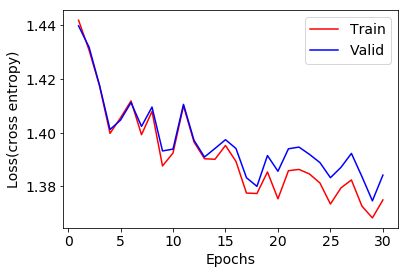

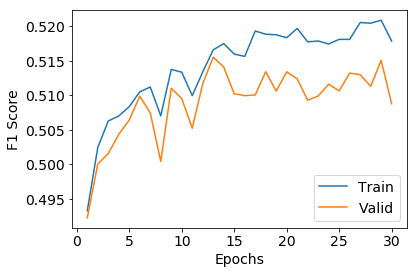

              precision    recall  f1-score   support

         joy       0.58      0.72      0.64      1928
     sadness       0.50      0.55      0.52      1800
        fear       0.61      0.53      0.57      1800
       anger       0.56      0.61      0.59      1672
anticipation       0.36      0.42      0.39      1800
       trust       0.67      0.40      0.50      1800
    surprise       0.43      0.40      0.41      1800
     disgust       0.48      0.47      0.47      1800

 avg / total       0.52      0.51      0.51     14400

Normalized confusion matrix


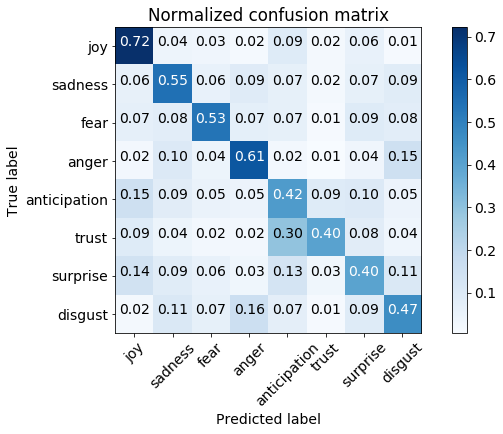

In [125]:
epochs_num = 30

# round_of_epochs = int(tweets_train.shape[0]/batch_size)
round_of_epochs = 2000
valid_round_of_epochs = int(tweets_valid.shape[0]/batch_size)
# valid_round_of_epochs = 1

train_loss = []
valid_loss = []
test_loss  = []

train_f1 = []
valid_f1 = []
test_f1 = []
x_axis = np.arange(0., epochs_num, 1) +1
# saver = tf.train.Saver() # to store the model

best_valid_acc = 0

testing_res = []
with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    for epochs in range(30): # starting the training process and set the epochs_num
        for _ in range(round_of_epochs):
            train, label = next(balance_train_iter) # Get the balance mini-batch data sample
            senti_logit = sess_senti.run([feature_map_senti, logit_senti], feed_dict={X_senti: train, Y_senti: label, mode_senti:False})
            emoti_logit = sess_emotion.run([feature_map_emo, logit_emo], feed_dict={X_emo: train, Y_emo: label, mode_emo:False})
            merge_res = np.concatenate(senti_logit+emoti_logit, 1)
            
            sess.run([train_step], feed_dict={concate_feature_map:merge_res, concate_y:label, concate_mode:True}) # Feed the features, labe, training_mode  to network to train
    
        # An epoch finish
        
        # Training evaluation
        train_res_loss, train_res_f1, train_res_acc, top2_train, _ = training_evaluation_merge(sess, sess_senti, sess_emotion, balance_train_iter, round_of_epochs)
        
        # Validation evaluation
        valid_res_loss, valid_res_f1, valid_res_acc, top2_valid, pred_label  = training_evaluation_merge(sess, sess_senti, sess_emotion, valid_iter_, valid_round_of_epochs)

        train_loss.append(train_res_loss)
        valid_loss.append(valid_res_loss)
        train_f1.append(train_res_f1)
        valid_f1.append(valid_res_f1)
        
#         test_pred, test_acc = sess.run([predicted_class, accuracy], feed_dict={X:tweets_test, y:senti_test, mode:False})
#         testing_res.append(test_pred)
        
        print("{} -{:3d} epoch, loss:{:.3f}/{:.3f}, accuracy:{:.3f}/{:.3f}, f1-score:{:.3f}/{:.3f}, top2 acc:{:.3f}/{:.3f}".format(
            datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            epochs+1,
            train_res_loss, 
            valid_res_loss,
            train_res_acc,
            valid_res_acc,
            train_res_f1,
            valid_res_f1,
            top2_train,
            top2_valid,
            )
        )
        classification_report_confusion_matrix(pred_label, class_names=['joy','sadness','fear','anger','anticipation','trust','surprise','disgust'], chart=False)
        
        
#         if best_valid_acc < valid_res_f1:
#             best_valid_acc = valid_res_f1
# #             save_path = saver.save(sess, "./model/emo_"+str(valid_res_f1)[2:5]+".ckpt")
        
    plt.rcParams['font.size'] = 14
    plt.plot(x_axis, train_loss, 'r', x_axis, valid_loss, 'b')
    plt.legend(['Train', 'Valid'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(cross entropy)')
    plt.show()
    plt.clf()
    plt.plot(x_axis, train_f1, x_axis, valid_f1)
    plt.legend(['Train', 'Valid'], loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.show()


    
    classification_report_confusion_matrix(pred_label, class_names=['joy','sadness','fear','anger','anticipation','trust','surprise','disgust'])

In [99]:
epochs_num = 30

# round_of_epochs = int(tweets_train.shape[0]/batch_size)
round_of_epochs = 2000
valid_round_of_epochs = int(tweets_valid.shape[0]/batch_size)
# valid_round_of_epochs = 1

train_loss = []
valid_loss = []
test_loss  = []

train_f1 = []
valid_f1 = []
test_f1 = []
x_axis = np.arange(0., epochs_num, 1) +1
saver = tf.train.Saver() # to store the model

best_valid_acc = 0

testing_res = []
with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    for epochs in range(epochs_num): # starting the training process and set the epochs_num
        for _ in range(round_of_epochs):
            train, label = next(balance_train_iter) # Get the balance mini-batch data sample
            senti_logit = sess_senti.run(feature_map_senti, feed_dict={X_senti: train, Y_senti: label, mode_senti:False})
            emoti_logit = sess_emotion.run(feature_map_emo, feed_dict={X_emo: train, Y_emo: label, mode_emo:False})
            merge_res = np.concatenate((senti_logit,emoti_logit), 1)
            
            sess.run([train_step], feed_dict={concate_feature_map:merge_res, concate_y:label, concate_mode:True}) # Feed the features, labe, training_mode  to network to train
    
        # An epoch finish
        
        # Training evaluation
        train_res_loss, train_res_f1, train_res_acc, top2_train, _ = training_evaluation_merge(sess, sess_senti, sess_emotion, balance_train_iter, round_of_epochs)
        
        # Validation evaluation
        valid_res_loss, valid_res_f1, valid_res_acc, top2_valid, pred_label  = training_evaluation_merge(sess, sess_senti, sess_emotion, valid_iter_, valid_round_of_epochs)

        train_loss.append(train_res_loss)
        valid_loss.append(valid_res_loss)
        train_f1.append(train_res_f1)
        valid_f1.append(valid_res_f1)
        
#         test_pred, test_acc = sess.run([predicted_class, accuracy], feed_dict={X:tweets_test, y:senti_test, mode:False})
#         testing_res.append(test_pred)
        
        print("{} -{:3d} epoch, loss:{:.3f}/{:.3f}, accuracy:{:.3f}/{:.3f}, f1-score:{:.3f}/{:.3f}, top2 acc:{:.3f}/{:.3f}".format(
            datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            epochs+1,
            train_res_loss, 
            valid_res_loss,
            train_res_acc,
            valid_res_acc,
            train_res_f1,
            valid_res_f1,
            top2_train,
            top2_valid,
            )
        )
        classification_report_confusion_matrix(pred_label, class_names=['joy','sadness','fear','anger','anticipation','trust','surprise','disgust'], chart=False)
        
        
#         if best_valid_acc < valid_res_f1:
#             best_valid_acc = valid_res_f1
# #             save_path = saver.save(sess, "./model/emo_"+str(valid_res_f1)[2:5]+".ckpt")
        
    plt.rcParams['font.size'] = 14
    plt.plot(x_axis, train_loss, 'r', x_axis, valid_loss, 'b')
    plt.legend(['Train', 'Valid'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(cross entropy)')
    plt.show()
    plt.clf()
    plt.plot(x_axis, train_f1, x_axis, valid_f1)
    plt.legend(['Train', 'Valid'], loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.show()

    classification_report_confusion_matrix(pred_label, class_names=['joy','sadness','fear','anger','anticipation','trust','surprise','disgust'])

2018-01-09 16:12:07 -  1 epoch, loss:1.368/1.369, accuracy:0.510/0.504, f1-score:0.504/0.498, top2 acc:0.701/0.703
              precision    recall  f1-score   support

         joy       0.57      0.73      0.64      1928
     sadness       0.46      0.52      0.49      1672
        fear       0.60      0.55      0.57      1800
       anger       0.57      0.61      0.59      1800
anticipation       0.35      0.29      0.31      1800
       trust       0.56      0.55      0.56      1800
    surprise       0.44      0.34      0.38      1800
     disgust       0.46      0.46      0.46      1800

 avg / total       0.50      0.51      0.50     14400

2018-01-09 16:12:36 -  2 epoch, loss:1.361/1.360, accuracy:0.513/0.510, f1-score:0.510/0.506, top2 acc:0.703/0.708
              precision    recall  f1-score   support

         joy       0.58      0.71      0.64      1928
     sadness       0.50      0.51      0.51      1672
        fear       0.59      0.55      0.57      1800
       ang

2018-01-09 16:18:23 - 14 epoch, loss:1.306/1.334, accuracy:0.535/0.523, f1-score:0.531/0.519, top2 acc:0.724/0.715
              precision    recall  f1-score   support

         joy       0.58      0.71      0.64      1800
     sadness       0.52      0.53      0.53      1800
        fear       0.59      0.56      0.58      1800
       anger       0.58      0.60      0.59      1800
anticipation       0.39      0.35      0.37      1800
       trust       0.56      0.58      0.57      1800
    surprise       0.49      0.37      0.42      1800
     disgust       0.47      0.50      0.48      1800

 avg / total       0.52      0.53      0.52     14400

2018-01-09 16:18:52 - 15 epoch, loss:1.302/1.330, accuracy:0.537/0.523, f1-score:0.534/0.521, top2 acc:0.726/0.718
              precision    recall  f1-score   support

         joy       0.59      0.70      0.64      1800
     sadness       0.51      0.54      0.52      1800
        fear       0.60      0.56      0.58      1800
       ang

2018-01-09 16:24:39 - 27 epoch, loss:1.267/1.324, accuracy:0.552/0.524, f1-score:0.548/0.522, top2 acc:0.737/0.719
              precision    recall  f1-score   support

         joy       0.60      0.70      0.65      1928
     sadness       0.54      0.50      0.52      1800
        fear       0.61      0.55      0.58      1800
       anger       0.59      0.60      0.60      1800
anticipation       0.40      0.37      0.39      1800
       trust       0.58      0.58      0.58      1800
    surprise       0.47      0.38      0.42      1800
     disgust       0.43      0.52      0.47      1672

 avg / total       0.53      0.53      0.53     14400

2018-01-09 16:25:08 - 28 epoch, loss:1.263/1.323, accuracy:0.556/0.525, f1-score:0.552/0.523, top2 acc:0.740/0.719
              precision    recall  f1-score   support

         joy       0.61      0.69      0.65      1928
     sadness       0.53      0.51      0.52      1800
        fear       0.59      0.58      0.58      1800
       ang

ValueError: x and y must have same first dimension, but have shapes (25,) and (30,)

## dropout 0.3, dense 512  & 512 & convolutional feature map layer & adam 0.0027

2018-01-09 15:39:33 -  1 epoch, loss:1.372/1.374, accuracy:0.508/0.504, f1-score:0.502/0.498, top2 acc:0.701/0.699
              precision    recall  f1-score   support

         joy       0.59      0.69      0.64      1928
     sadness       0.53      0.49      0.51      1800
        fear       0.53      0.60      0.56      1800
       anger       0.60      0.57      0.58      1800
anticipation       0.36      0.29      0.32      1760
       trust       0.51      0.55      0.53      1712
    surprise       0.46      0.34      0.39      1800
     disgust       0.44      0.51      0.47      1800

 avg / total       0.50      0.51      0.50     14400

2018-01-09 15:40:02 -  2 epoch, loss:1.360/1.358, accuracy:0.514/0.517, f1-score:0.510/0.514, top2 acc:0.705/0.705
              precision    recall  f1-score   support

         joy       0.59      0.70      0.64      1928
     sadness       0.54      0.49      0.51      1800
        fear       0.58      0.59      0.59      1800
       ang

2018-01-09 15:45:49 - 14 epoch, loss:1.306/1.334, accuracy:0.537/0.521, f1-score:0.535/0.520, top2 acc:0.725/0.716
              precision    recall  f1-score   support

         joy       0.60      0.71      0.65      1928
     sadness       0.52      0.51      0.52      1800
        fear       0.59      0.55      0.57      1800
       anger       0.59      0.61      0.60      1800
anticipation       0.36      0.38      0.37      1672
       trust       0.63      0.52      0.57      1800
    surprise       0.46      0.38      0.42      1800
     disgust       0.45      0.53      0.48      1800

 avg / total       0.53      0.53      0.52     14400

2018-01-09 15:46:18 - 15 epoch, loss:1.298/1.328, accuracy:0.538/0.523, f1-score:0.536/0.522, top2 acc:0.726/0.718
              precision    recall  f1-score   support

         joy       0.61      0.70      0.65      1928
     sadness       0.53      0.52      0.52      1800
        fear       0.58      0.56      0.57      1800
       ang

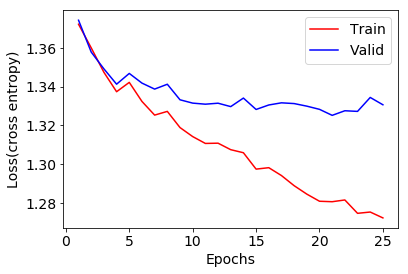

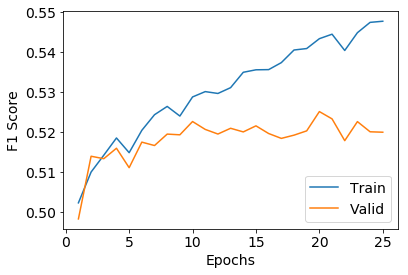

              precision    recall  f1-score   support

         joy       0.60      0.71      0.65      1928
     sadness       0.50      0.54      0.52      1800
        fear       0.60      0.56      0.58      1800
       anger       0.59      0.57      0.58      1672
anticipation       0.39      0.36      0.38      1800
       trust       0.60      0.57      0.58      1800
    surprise       0.46      0.39      0.42      1800
     disgust       0.46      0.49      0.48      1800

 avg / total       0.52      0.53      0.52     14400

Normalized confusion matrix


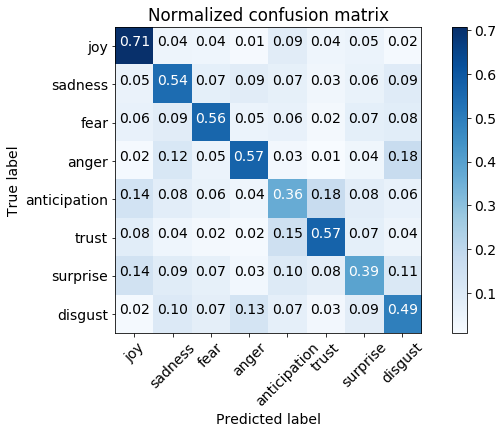

In [96]:
# round_of_epochs = int(tweets_train.shape[0]/batch_size)
round_of_epochs = 2000
valid_round_of_epochs = int(tweets_valid.shape[0]/batch_size)
# valid_round_of_epochs = 1

train_loss = []
valid_loss = []
test_loss  = []

train_f1 = []
valid_f1 = []
test_f1 = []
x_axis = np.arange(0., epochs_num, 1) +1
saver = tf.train.Saver() # to store the model

best_valid_acc = 0

testing_res = []
with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    for epochs in range(epochs_num): # starting the training process and set the epochs_num
        for _ in range(round_of_epochs):
            train, label = next(balance_train_iter) # Get the balance mini-batch data sample
            senti_logit = sess_senti.run(feature_map_senti, feed_dict={X_senti: train, Y_senti: label, mode_senti:False})
            emoti_logit = sess_emotion.run(feature_map_emo, feed_dict={X_emo: train, Y_emo: label, mode_emo:False})
            merge_res = np.concatenate((senti_logit,emoti_logit), 1)
            
            sess.run([train_step], feed_dict={concate_feature_map:merge_res, concate_y:label, concate_mode:True}) # Feed the features, labe, training_mode  to network to train
    
        # An epoch finish
        
        # Training evaluation
        train_res_loss, train_res_f1, train_res_acc, top2_train, _ = training_evaluation_merge(sess, sess_senti, sess_emotion, balance_train_iter, round_of_epochs)
        
        # Validation evaluation
        valid_res_loss, valid_res_f1, valid_res_acc, top2_valid, pred_label  = training_evaluation_merge(sess, sess_senti, sess_emotion, valid_iter_, valid_round_of_epochs)

        train_loss.append(train_res_loss)
        valid_loss.append(valid_res_loss)
        train_f1.append(train_res_f1)
        valid_f1.append(valid_res_f1)
        
#         test_pred, test_acc = sess.run([predicted_class, accuracy], feed_dict={X:tweets_test, y:senti_test, mode:False})
#         testing_res.append(test_pred)
        
        print("{} -{:3d} epoch, loss:{:.3f}/{:.3f}, accuracy:{:.3f}/{:.3f}, f1-score:{:.3f}/{:.3f}, top2 acc:{:.3f}/{:.3f}".format(
            datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            epochs+1,
            train_res_loss, 
            valid_res_loss,
            train_res_acc,
            valid_res_acc,
            train_res_f1,
            valid_res_f1,
            top2_train,
            top2_valid,
            )
        )
        classification_report_confusion_matrix(pred_label, class_names=['joy','sadness','fear','anger','anticipation','trust','surprise','disgust'], chart=False)
        
        
#         if best_valid_acc < valid_res_f1:
#             best_valid_acc = valid_res_f1
# #             save_path = saver.save(sess, "./model/emo_"+str(valid_res_f1)[2:5]+".ckpt")
        
    plt.rcParams['font.size'] = 14
    plt.plot(x_axis, train_loss, 'r', x_axis, valid_loss, 'b')
    plt.legend(['Train', 'Valid'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(cross entropy)')
    plt.show()
    plt.clf()
    plt.plot(x_axis, train_f1, x_axis, valid_f1)
    plt.legend(['Train', 'Valid'], loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.show()

    classification_report_confusion_matrix(pred_label, class_names=['joy','sadness','fear','anger','anticipation','trust','surprise','disgust'])

## dropout 0.3, dense 512  & 512 & convolutional feature map layer & adam 0.0017

2018-01-09 15:14:06 -  1 epoch, loss:1.379/1.375, accuracy:0.507/0.506, f1-score:0.502/0.501, top2 acc:0.697/0.701
              precision    recall  f1-score   support

         joy       0.59      0.72      0.65      1928
     sadness       0.50      0.54      0.52      1800
        fear       0.55      0.58      0.57      1800
       anger       0.59      0.59      0.59      1800
anticipation       0.35      0.30      0.32      1800
       trust       0.59      0.52      0.55      1800
    surprise       0.45      0.31      0.37      1672
     disgust       0.42      0.49      0.45      1800

 avg / total       0.51      0.51      0.51     14400

2018-01-09 15:14:35 -  2 epoch, loss:1.359/1.361, accuracy:0.513/0.512, f1-score:0.506/0.505, top2 acc:0.703/0.707
              precision    recall  f1-score   support

         joy       0.59      0.71      0.64      1928
     sadness       0.50      0.53      0.52      1800
        fear       0.56      0.58      0.57      1800
       ang

2018-01-09 15:20:22 - 14 epoch, loss:1.308/1.332, accuracy:0.534/0.521, f1-score:0.532/0.519, top2 acc:0.722/0.719
              precision    recall  f1-score   support

         joy       0.59      0.72      0.65      1928
     sadness       0.51      0.54      0.53      1800
        fear       0.59      0.56      0.57      1800
       anger       0.59      0.60      0.60      1800
anticipation       0.39      0.37      0.38      1800
       trust       0.61      0.51      0.56      1672
    surprise       0.47      0.37      0.42      1800
     disgust       0.44      0.51      0.47      1800

 avg / total       0.53      0.53      0.52     14400

2018-01-09 15:20:51 - 15 epoch, loss:1.308/1.332, accuracy:0.536/0.523, f1-score:0.534/0.521, top2 acc:0.724/0.720
              precision    recall  f1-score   support

         joy       0.60      0.69      0.65      1928
     sadness       0.52      0.52      0.52      1800
        fear       0.57      0.59      0.58      1800
       ang

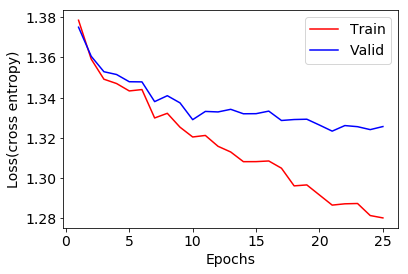

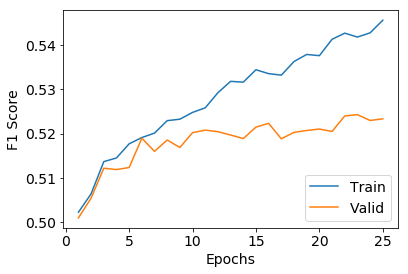

              precision    recall  f1-score   support

         joy       0.60      0.71      0.65      1928
     sadness       0.51      0.54      0.52      1800
        fear       0.59      0.58      0.58      1800
       anger       0.59      0.61      0.60      1800
anticipation       0.39      0.39      0.39      1800
       trust       0.60      0.54      0.57      1672
    surprise       0.47      0.38      0.42      1800
     disgust       0.46      0.48      0.47      1800

 avg / total       0.53      0.53      0.53     14400

Normalized confusion matrix


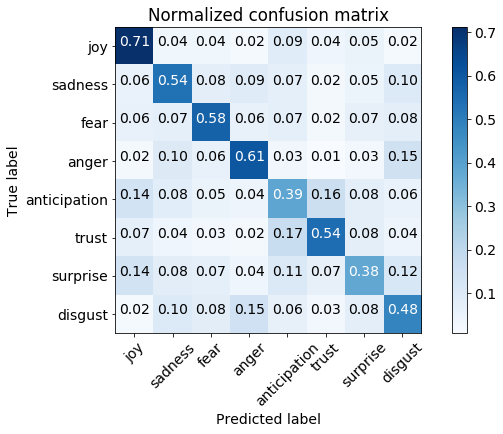

In [94]:
# round_of_epochs = int(tweets_train.shape[0]/batch_size)
round_of_epochs = 2000
valid_round_of_epochs = int(tweets_valid.shape[0]/batch_size)
# valid_round_of_epochs = 1

train_loss = []
valid_loss = []
test_loss  = []

train_f1 = []
valid_f1 = []
test_f1 = []
x_axis = np.arange(0., epochs_num, 1) +1
saver = tf.train.Saver() # to store the model

best_valid_acc = 0

testing_res = []
with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    for epochs in range(epochs_num): # starting the training process and set the epochs_num
        for _ in range(round_of_epochs):
            train, label = next(balance_train_iter) # Get the balance mini-batch data sample
            senti_logit = sess_senti.run(feature_map_senti, feed_dict={X_senti: train, Y_senti: label, mode_senti:False})
            emoti_logit = sess_emotion.run(feature_map_emo, feed_dict={X_emo: train, Y_emo: label, mode_emo:False})
            merge_res = np.concatenate((senti_logit,emoti_logit), 1)
            
            sess.run([train_step], feed_dict={concate_feature_map:merge_res, concate_y:label, concate_mode:True}) # Feed the features, labe, training_mode  to network to train
    
        # An epoch finish
        
        # Training evaluation
        train_res_loss, train_res_f1, train_res_acc, top2_train, _ = training_evaluation_merge(sess, sess_senti, sess_emotion, balance_train_iter, round_of_epochs)
        
        # Validation evaluation
        valid_res_loss, valid_res_f1, valid_res_acc, top2_valid, pred_label  = training_evaluation_merge(sess, sess_senti, sess_emotion, valid_iter_, valid_round_of_epochs)

        train_loss.append(train_res_loss)
        valid_loss.append(valid_res_loss)
        train_f1.append(train_res_f1)
        valid_f1.append(valid_res_f1)
        
#         test_pred, test_acc = sess.run([predicted_class, accuracy], feed_dict={X:tweets_test, y:senti_test, mode:False})
#         testing_res.append(test_pred)
        
        print("{} -{:3d} epoch, loss:{:.3f}/{:.3f}, accuracy:{:.3f}/{:.3f}, f1-score:{:.3f}/{:.3f}, top2 acc:{:.3f}/{:.3f}".format(
            datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            epochs+1,
            train_res_loss, 
            valid_res_loss,
            train_res_acc,
            valid_res_acc,
            train_res_f1,
            valid_res_f1,
            top2_train,
            top2_valid,
            )
        )
        classification_report_confusion_matrix(pred_label, class_names=['joy','sadness','fear','anger','anticipation','trust','surprise','disgust'], chart=False)
        
        
#         if best_valid_acc < valid_res_f1:
#             best_valid_acc = valid_res_f1
# #             save_path = saver.save(sess, "./model/emo_"+str(valid_res_f1)[2:5]+".ckpt")
        
    plt.rcParams['font.size'] = 14
    plt.plot(x_axis, train_loss, 'r', x_axis, valid_loss, 'b')
    plt.legend(['Train', 'Valid'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(cross entropy)')
    plt.show()
    plt.clf()
    plt.plot(x_axis, train_f1, x_axis, valid_f1)
    plt.legend(['Train', 'Valid'], loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.show()

    classification_report_confusion_matrix(pred_label, class_names=['joy','sadness','fear','anger','anticipation','trust','surprise','disgust'])

## dropout 0.3, dense 512  & 512 & convolutional feature map layer

2018-01-09 01:17:48 -  1 epoch, loss:1.380/1.384, accuracy:0.507/0.503, f1-score:0.502/0.498, top2 acc:0.699/0.701
              precision    recall  f1-score   support

         joy       0.57      0.73      0.64      1928
     sadness       0.53      0.47      0.50      1800
        fear       0.56      0.55      0.55      1672
       anger       0.53      0.67      0.59      1800
anticipation       0.35      0.37      0.36      1800
       trust       0.61      0.49      0.54      1800
    surprise       0.48      0.31      0.38      1800
     disgust       0.44      0.47      0.45      1800

 avg / total       0.51      0.51      0.50     14400

2018-01-09 01:18:16 -  2 epoch, loss:1.361/1.366, accuracy:0.515/0.509, f1-score:0.511/0.505, top2 acc:0.706/0.705
              precision    recall  f1-score   support

         joy       0.59      0.71      0.64      1928
     sadness       0.54      0.47      0.51      1800
        fear       0.57      0.55      0.56      1672
       ang

2018-01-09 01:24:04 - 14 epoch, loss:1.315/1.339, accuracy:0.535/0.522, f1-score:0.533/0.520, top2 acc:0.725/0.717
              precision    recall  f1-score   support

         joy       0.60      0.70      0.65      1928
     sadness       0.49      0.52      0.50      1672
        fear       0.61      0.54      0.57      1800
       anger       0.58      0.60      0.59      1800
anticipation       0.40      0.37      0.38      1800
       trust       0.60      0.55      0.57      1800
    surprise       0.46      0.39      0.42      1800
     disgust       0.46      0.52      0.49      1800

 avg / total       0.53      0.53      0.52     14400

2018-01-09 01:24:33 - 15 epoch, loss:1.313/1.339, accuracy:0.535/0.522, f1-score:0.534/0.521, top2 acc:0.724/0.715
              precision    recall  f1-score   support

         joy       0.61      0.70      0.65      1928
     sadness       0.47      0.53      0.50      1672
        fear       0.61      0.52      0.56      1800
       ang

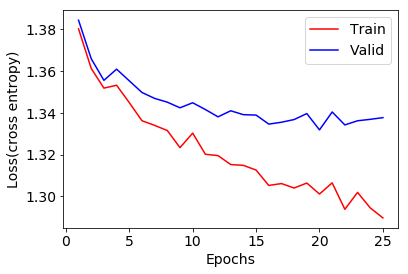

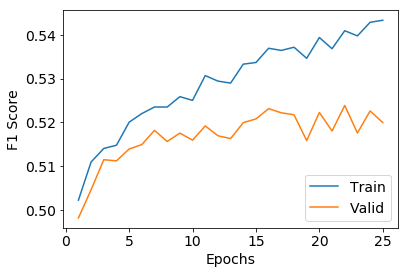

              precision    recall  f1-score   support

         joy       0.61      0.70      0.65      1928
     sadness       0.48      0.53      0.51      1672
        fear       0.60      0.56      0.58      1800
       anger       0.57      0.62      0.59      1800
anticipation       0.40      0.37      0.39      1800
       trust       0.59      0.56      0.58      1800
    surprise       0.47      0.39      0.43      1800
     disgust       0.47      0.47      0.47      1800

 avg / total       0.52      0.53      0.52     14400

Normalized confusion matrix


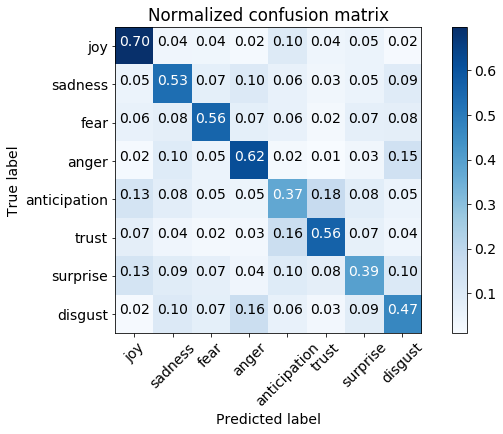

In [86]:
# round_of_epochs = int(tweets_train.shape[0]/batch_size)
round_of_epochs = 2000
valid_round_of_epochs = int(tweets_valid.shape[0]/batch_size)
# valid_round_of_epochs = 1

train_loss = []
valid_loss = []
test_loss  = []

train_f1 = []
valid_f1 = []
test_f1 = []
x_axis = np.arange(0., epochs_num, 1) +1
saver = tf.train.Saver() # to store the model

best_valid_acc = 0

testing_res = []
with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    for epochs in range(epochs_num): # starting the training process and set the epochs_num
        for _ in range(round_of_epochs):
            train, label = next(balance_train_iter) # Get the balance mini-batch data sample
            senti_logit = sess_senti.run(feature_map_senti, feed_dict={X_senti: train, Y_senti: label, mode_senti:False})
            emoti_logit = sess_emotion.run(feature_map_emo, feed_dict={X_emo: train, Y_emo: label, mode_emo:False})
            merge_res = np.concatenate((senti_logit,emoti_logit), 1)
            
            sess.run([train_step], feed_dict={concate_feature_map:merge_res, concate_y:label, concate_mode:True}) # Feed the features, labe, training_mode  to network to train
    
        # An epoch finish
        
        # Training evaluation
        train_res_loss, train_res_f1, train_res_acc, top2_train, _ = training_evaluation_merge(sess, sess_senti, sess_emotion, balance_train_iter, round_of_epochs)
        
        # Validation evaluation
        valid_res_loss, valid_res_f1, valid_res_acc, top2_valid, pred_label  = training_evaluation_merge(sess, sess_senti, sess_emotion, valid_iter_, valid_round_of_epochs)

        train_loss.append(train_res_loss)
        valid_loss.append(valid_res_loss)
        train_f1.append(train_res_f1)
        valid_f1.append(valid_res_f1)
        
#         test_pred, test_acc = sess.run([predicted_class, accuracy], feed_dict={X:tweets_test, y:senti_test, mode:False})
#         testing_res.append(test_pred)
        
        print("{} -{:3d} epoch, loss:{:.3f}/{:.3f}, accuracy:{:.3f}/{:.3f}, f1-score:{:.3f}/{:.3f}, top2 acc:{:.3f}/{:.3f}".format(
            datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            epochs+1,
            train_res_loss, 
            valid_res_loss,
            train_res_acc,
            valid_res_acc,
            train_res_f1,
            valid_res_f1,
            top2_train,
            top2_valid,
            )
        )
        classification_report_confusion_matrix(pred_label, class_names=['joy','sadness','fear','anger','anticipation','trust','surprise','disgust'], chart=False)
        
        
#         if best_valid_acc < valid_res_f1:
#             best_valid_acc = valid_res_f1
# #             save_path = saver.save(sess, "./model/emo_"+str(valid_res_f1)[2:5]+".ckpt")
        
    plt.rcParams['font.size'] = 14
    plt.plot(x_axis, train_loss, 'r', x_axis, valid_loss, 'b')
    plt.legend(['Train', 'Valid'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(cross entropy)')
    plt.show()
    plt.clf()
    plt.plot(x_axis, train_f1, x_axis, valid_f1)
    plt.legend(['Train', 'Valid'], loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.show()

    classification_report_confusion_matrix(pred_label, class_names=['joy','sadness','fear','anger','anticipation','trust','surprise','disgust'])

In [40]:
del senti_graph, emotion_graph